# Baseline Model

## Table of Contents
1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


In [1]:
#import necessary libraries
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

warnings.filterwarnings('ignore')

## Model Choice

Since a simple but strong characteristic of the dataset is the seasonality, we desided here to only consider the mean climatology as baseline model.
In a second baseline model we desided to take seasonal ARIMA since it dynamically includes the season.

## Feature Selection

For the seasonality in the dataset only the timeseries itselve is taken. So we don't take any features for the baselinemodel.

In [2]:
# Load the NAO daily dataset
url = "https://ftp.cpc.ncep.noaa.gov/cwlinks/norm.daily.nao.cdas.z500.19500101_current.csv"
df = pd.read_csv(url)

# Clean and index time
df['time'] = pd.to_datetime(df[['year','month','day']])
df = df.set_index('time')

# Feature Engineering: Seasonality and Decades
# Winter (Nov-Apr) vs Summer (May-Oct)
winter_months = {11, 12, 1, 2, 3, 4}
df['season_flag'] = df['month'].apply(lambda m: 1 if m in winter_months else -1)
df['decade'] = df['year'] // 10 * 10

# Drop redundant columns
df.drop(columns=['day', 'year'], inplace=True)

# Convert to xarray for professional climate data handling
ds = xr.Dataset.from_dataframe(df)

def fill_nans_weighted(ds, dim, n=3):
    """Fills NaNs using a weighted rolling mean (n neighbors)."""
    window = 2 * n + 1
    weights = np.ones(window) / window
    rolled = ds.rolling({dim: window}, center=True).construct("window")
    filled = (rolled * xr.DataArray(weights, dims=["window"])).sum("window")
    return ds.fillna(filled)

ds = fill_nans_weighted(ds, dim='time', n=3)

In [3]:
# Resample daily NAO to monthly mean
ds_monthly = ds.resample(time="ME").mean()

# Convert to pandas DataFrame if needed
df_monthly = ds_monthly.to_dataframe()

df_monthly


,month,nao_index_cdas,season_flag,decade
time,,,,
1950-01-31,1.0,0.463516,1.0,1950.0
1950-02-28,2.0,0.420714,1.0,1950.0
1950-03-31,3.0,0.008387,1.0,1950.0
1950-04-30,4.0,0.239433,1.0,1950.0
1950-05-31,5.0,-0.261226,-1.0,1950.0
...,...,...,...,...
2025-09-30,9.0,-0.373873,-1.0,2020.0
2025-10-31,10.0,-0.398225,-1.0,2020.0
2025-11-30,11.0,-0.434436,1.0,2020.0


In [4]:
# 80:20 split into train and test sets

# Target variable
nao = df_monthly["nao_index_cdas"]

# Total number of samples
n_total = len(nao)

# 80% training split
n_train = int(0.8 * n_total)

# Chronological split
train = nao.iloc[:n_train]
test = nao.iloc[n_train:]



In [5]:
test

,nao_index_cdas
time,
2010-11-30,-0.931782
2010-12-31,-1.172053
2011-01-31,-0.440003
2011-02-28,0.528588
2011-03-31,0.358732
...,...
2025-09-30,-0.373873
2025-10-31,-0.398225
2025-11-30,-0.434436


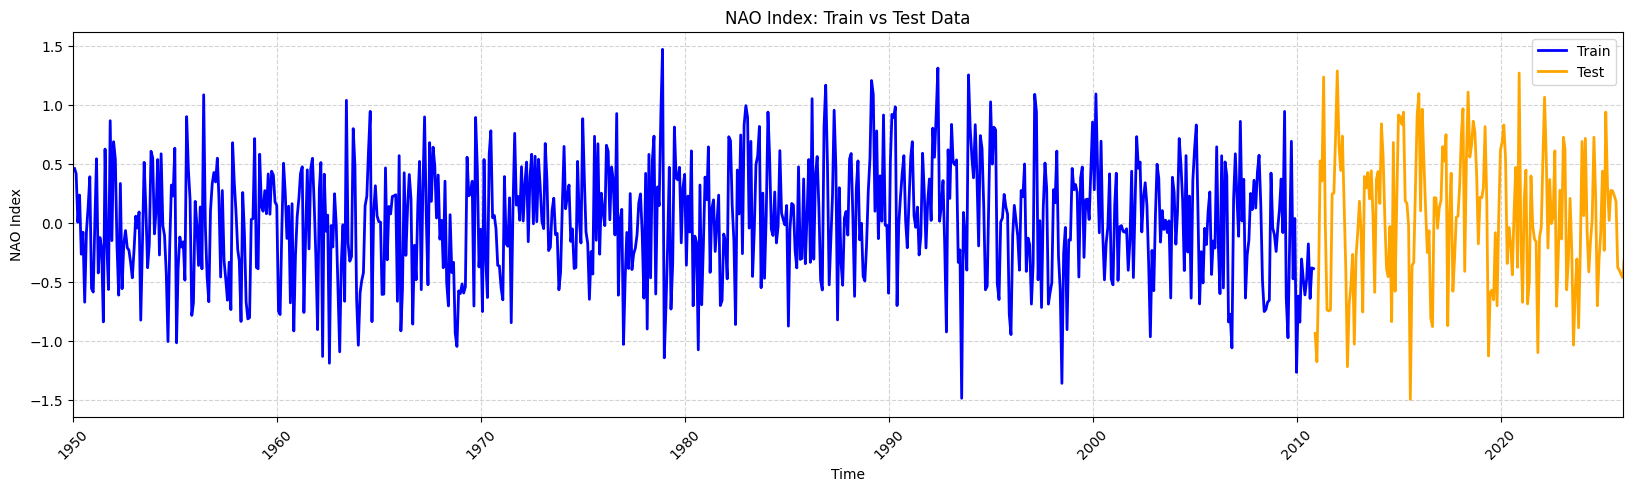

In [6]:
plt.figure(figsize=[20,5])

# Plot train and test
plt.plot(df_monthly.index[:n_train], train, label='Train', color='blue', linewidth=2)
plt.plot(df_monthly.index[n_train:], test, label='Test', color='orange', linewidth=2)

# Labels and title
plt.xlabel('Time')
plt.ylabel('NAO Index')
plt.title('NAO Index: Train vs Test Data')

# Styling
plt.legend()
plt.grid(linestyle='--', color='lightgrey')
plt.xlim(pd.Timestamp('1950-01-01'), pd.Timestamp('2026-01-01'))
plt.xticks(rotation=45)
plt.show()


## Implementation

Walk-Forward Validation Setup


In [7]:
# Target variable
data = df_monthly["nao_index_cdas"].values

# Train-test split (time-aware)
n_total = len(data)
n_train = int(0.8 * n_total)

train = data[:n_train]
test = data[n_train:]

# Initialize history and prediction containers
history = list(train)
predictions_clim = []
predictions_sarima = []

print(f"Initial training length: {len(history)}")
print(f"Forecast horizon:        {len(test)} months")


Initial training length: 730
Forecast horizon:        183 months


Walk-Forward Forecast Loop

In [8]:
for t in range(len(test)):

    # ============================
    # Model 1: Monthly Climatology
    # ============================
    current_month = df_monthly.index[n_train + t].month
    past_index = df_monthly.index[:n_train + t]
    mask = past_index.month == current_month

    clim_pred = df_monthly["nao_index_cdas"][:n_train + t][mask].mean()
    predictions_clim.append(clim_pred)

    # ============================
    # Model 2: SARIMA
    # ============================
    model = SARIMAX(
        history,
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    model_fit = model.fit(disp=False)
    sarima_pred = model_fit.forecast()[0]
    predictions_sarima.append(sarima_pred)

    # ============================
    # Update history
    # ============================
    history.append(test[t])

    if t % 20 == 0:
        print(f"Step {t}/{len(test)} completed")


Step 0/183 completed
Step 20/183 completed
Step 40/183 completed
Step 60/183 completed
Step 140/183 completed
Step 160/183 completed
Step 180/183 completed


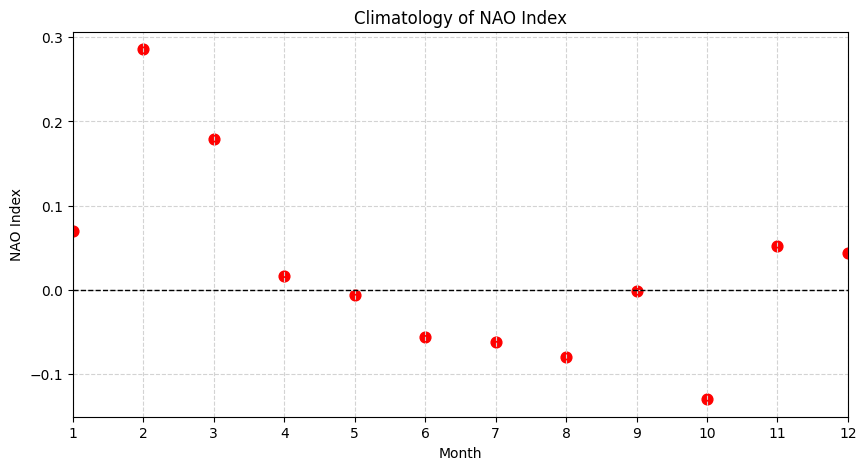

In [9]:
# Compute monthly climatology (average NAO per month)
climatology = df_monthly.groupby(df_monthly.index.month)['nao_index_cdas'].mean().reset_index()
climatology.rename(columns={'time': 'month'}, inplace=True)  
# Plot
plt.figure(figsize=(10,5))
plt.scatter(climatology.index + 1, climatology['nao_index_cdas'], color='red', s=60)  # months 1-12
plt.grid(linestyle='--', color='lightgrey')
plt.xlabel('Month')
plt.ylabel('NAO Index')
plt.title('Climatology of NAO Index')
plt.hlines(y=0, xmin=1, xmax=12, linestyle='--', color='black', linewidth=1)
plt.xlim(1, 12)
plt.xticks(range(1,13))
plt.show()


## Or do all this with a "real" basline model seasonal ARIMA (SARIMA)

## Evaluation

mse: Mean squared error

rmse: Root mean squared error

acc: Anomaly Correlation Coefficient: Sign of NAO is maybe more important then difference.



In [10]:
# Evaluate the baseline model

def anomaly_correlation(observed, predicted):
    """
    Compute Anomaly Correlation Coefficient (ACC)
    """
    return np.corrcoef(observed, predicted)[0, 1]
# Convert predictions to numpy arrays
predictions_clim = np.array(predictions_clim)
predictions_sarima = np.array(predictions_sarima)

# Error metrics
rmse_clim = np.sqrt(mean_squared_error(test, predictions_clim))
rmse_sarima = np.sqrt(mean_squared_error(test, predictions_sarima))

mse_clim = rmse_clim ** 2
mse_sarima = rmse_sarima ** 2
# Skill metrics
acc_clim = anomaly_correlation(test, predictions_clim)
acc_sarima = anomaly_correlation(test, predictions_sarima)

print("=" * 35)
print("FINAL EVALUATION RESULTS")
print("=" * 35)
print(f"MSE  (Climatology): {mse_clim:.4f}")
print(f"MSE  (SARIMA):      {mse_sarima:.4f}")
print(f"RMSE (Climatology): {rmse_clim:.4f}")
print(f"RMSE (SARIMA):      {rmse_sarima:.4f}")
print(f"ACC  (Climatology): {acc_clim:.4f}")
print(f"ACC  (SARIMA):      {acc_sarima:.4f}")


FINAL EVALUATION RESULTS
MSE  (Climatology): 0.2880
MSE  (SARIMA):      0.2613
RMSE (Climatology): 0.5366
RMSE (SARIMA):      0.5112
ACC  (Climatology): 0.3895
ACC  (SARIMA):      0.4334


Visualization

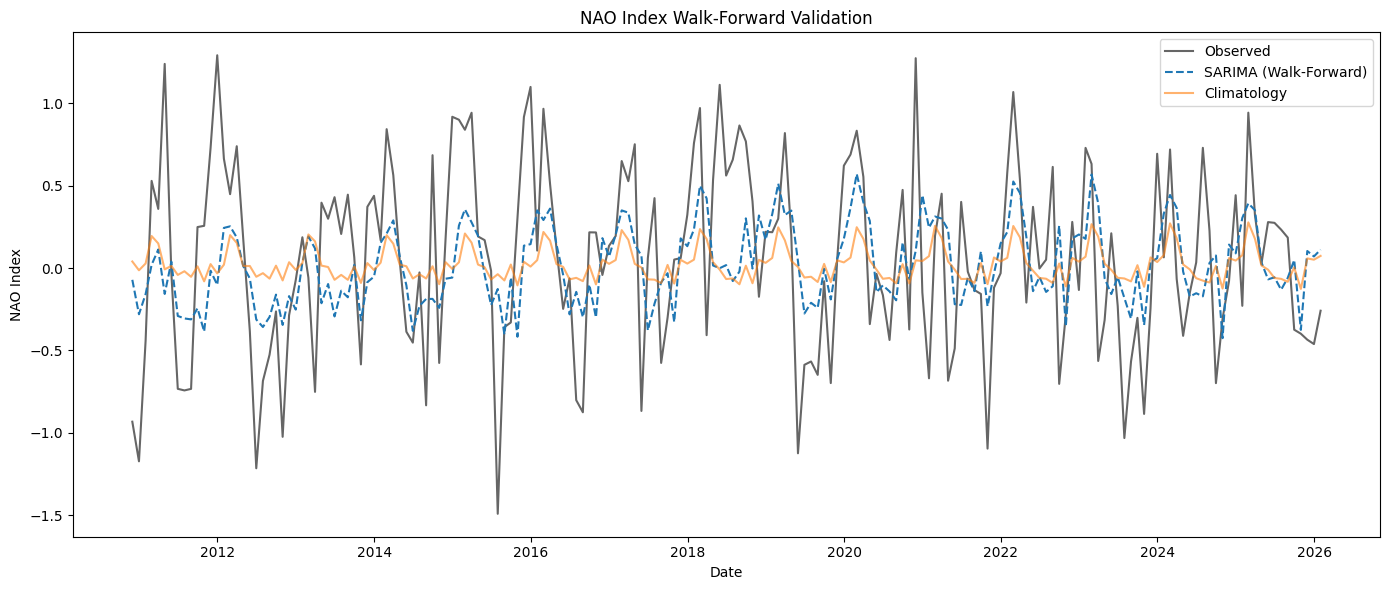

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

plt.plot(
    df_monthly.index[n_train:],
    test,
    label="Observed",
    color="black",
    alpha=0.6
)

plt.plot(
    df_monthly.index[n_train:],
    predictions_sarima,
    label="SARIMA (Walk-Forward)",
    linestyle="--"
)

plt.plot(
    df_monthly.index[n_train:],
    predictions_clim,
    label="Climatology",
    alpha=0.6
)

plt.title("NAO Index Walk-Forward Validation")
plt.xlabel("Date")
plt.ylabel("NAO Index")
plt.legend()
plt.tight_layout()
plt.show()


In [12]:

import json

baseline_results = {
    "mse_sarima": float(mse_sarima),
    "rmse_sarima": float(rmse_sarima),
    "acc_sarima": float(acc_sarima)
}

with open("baseline_results.json", "w") as f:
    json.dump(baseline_results, f, indent=4)

print("\nBaseline metrics saved to baseline_results.json")



Baseline metrics saved to baseline_results.json
